In [1]:
%matplotlib notebook
import logging
import os
import math
import multiprocessing
import json
import re

from scipy.stats import t
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import natsort

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

plt.rc("font", size=14)
plt.rc("axes", titlesize=14)
plt.rc("axes", labelsize=14)
plt.rc("xtick", labelsize=14)
plt.rc("ytick", labelsize=14)
plt.rc("legend", fontsize=14)
plt.rc("figure", titlesize=14)

In [11]:
csv_file_name = "raw-CBR.csv"
for config in configs:
    print("===============================\n{}\n===============================\n".format(config))
    for density in configs[config]:
        df = pd.read_csv("{}/{}".format(configs[config][density], csv_file_name))
        print("{}: {} +/- {}".format(density, df["cbr"].mean(), df["cbr"].std()))

periodic

0.06: 0.262543077956962 +/- 0.05281335129637487
0.12: 0.44461098712209063 +/- 0.0672477407750817
0.2: 0.6745769389646326 +/- 0.0876089633457672
0.3: 0.8310114898808652 +/- 0.07728826207685739
3GPP

0.06: 0.23619233173391505 +/- 0.04519789553044664
0.12: 0.42359247330525823 +/- 0.0671220480630004
0.2: 0.645836923210253 +/- 0.0860958449458266
0.3: 0.7949148252649083 +/- 0.07898197338950338
ETSI

0.06: 0.21861136213523344 +/- 0.04109057414120169
0.12: 0.27115032003940764 +/- 0.0481369457209863
0.2: 0.2825065376439743 +/- 0.053612206023020595
0.3: 0.2488734548883904 +/- 0.05059562607410891
SingleSlot

0.06: 0.21298087663422852 +/- 0.041522054706447625
0.12: 0.3641709234765595 +/- 0.05888569326004756
0.2: 0.4916022646284688 +/- 0.06460579920486771
0.3: 0.5583039077794159 +/- 0.06222481765352411


In [2]:
def cbr_graph(folders, graph_type, graph_title, graph_info, now):
    # Might change this to time based graph but CBR is fine for now
    times = []
    raw_times = []
    cbrs = []
    cis = []
    box_plot_data = []
    for folder in folders:
        df = pd.read_csv("{}/CBR.csv".format(folder))
        cbr = list(df["Mean"])
        ci = list(df["Confidence-Interval"])

        # Transform 0-1 to 0-100
        for i in range(len(cbr)):
            cbr[i] = cbr[i] * 100
            ci[i] = ci[i] * 100

        times.append(list(df["Time"]))
        cbrs.append(cbr)
        cis.append(ci)

        cbr_csv = "{}/raw-CBR.csv".format(folder)
        df = pd.read_csv(cbr_csv)
        box_plot_data.append(list(100 * df["cbr"]))
        raw_times.append(list(df["Time"]))

    graph_info["means"] = cbrs
    graph_info["times"] = times
    graph_info["cis"] = cis
    graph_info["boxplotData"] = box_plot_data
    graph_info["raw_times"] = raw_times

    cbr_plot(graph_info, "{}-{}".format(graph_title, graph_type), now=now,
             confidence_intervals=False, show=False, store=True)
    
    cbr_plot_raw(graph_info, "{}-{}".format(graph_title, graph_type), now=now,
                 confidence_intervals=False, show=False, store=True)

In [3]:
def cbr_plot_bar(graph_info, plot_name, now, confidence_intervals=False, show=True, store=False):

    fig, ax = plt.subplots()

    for i in range(len(graph_info["config_name"])):
        ax.scatter(graph_info["raw_times"][i], graph_info["boxplotData"][i], label=graph_info["labels"][i],
                   marker=graph_info["markers"][i], c=graph_info["colors"][i])
        
        if graph_info["labels"][i] == "Simulated Low":
            cbr_value = [40] * len(graph_info["times"][i])
            
            ax.plot(graph_info["times"][i], cbr_value,
                    marker=graph_info["markers"][i], markevery=5, fillstyle="none",
                    color="purple", linestyle="solid")
                
        elif graph_info["labels"][i] == "Simulated Medium":
            cbr_value = [51] * len(graph_info["times"][i])

            ax.plot(graph_info["times"][i], cbr_value,
                    marker=graph_info["markers"][i], markevery=5, fillstyle="none",
                    color="green", linestyle="solid")
                
        elif graph_info["labels"][i] == "Simulated High":
            cbr_value = [74] * len(graph_info["times"][i])
                
            ax.plot(graph_info["times"][i], cbr_value, label="Analytical",
                    marker=graph_info["markers"][i], markevery=5, fillstyle="none",
                    color="orange", linestyle="solid")
            
    
#     ax.legend(loc='lower left')
    ax.set(xlabel='Time (s)', ylabel='Channel Busy Ratio %')
    ax.tick_params(direction='in')

    ax.set_ylim([0, 100])
    plt.yticks(np.arange(0, 101, step=10))
    plt.grid(b=True, alpha=0.5)
    
    plt.legend(fontsize='small', handleheight=2, labelspacing=0.05, loc='lower right')

    if store:

        fig.savefig("{}-raw.png".format(plot_name), dpi=400)
    plt.close(fig)

In [4]:
def cbr_plot_box(graph_info, plot_name, now, confidence_intervals=False, show=True, store=False):

    fig, ax = plt.subplots()

    for i in range(len(graph_info["config_name"])):
        ax.scatter(graph_info["raw_times"][i], graph_info["boxplotData"][i], label=graph_info["labels"][i],
                   marker=graph_info["markers"][i], c=graph_info["colors"][i])
        
        if graph_info["labels"][i] == "Simulated Low":
            cbr_value = [29] * len(np.arange(501, 512,))
            
            ax.plot(graph_info["times"][i], cbr_value, label="Analytical Low",
                    marker=graph_info["markers"][i], markevery=5, fillstyle="none",
                    color="purple", linestyle="solid")
                
        elif graph_info["labels"][i] == "Simulated Medium":
            cbr_value = [51] * len(graph_info["times"][i])

            ax.plot(graph_info["times"][i], cbr_value, label="Analytical Medium",
                    marker=graph_info["markers"][i], markevery=5, fillstyle="none",
                    color="green", linestyle="solid")
                
        elif graph_info["labels"][i] == "Simulated High":
            cbr_value = [74] * len(graph_info["times"][i])
                
            ax.plot(graph_info["times"][i], cbr_value, label="Analytical High",
                    marker=graph_info["markers"][i], markevery=5, fillstyle="none",
                    color="orange", linestyle="solid")
            
    
#     ax.legend(loc='lower left')
    ax.set(xlabel='Time (s)', ylabel='Channel Busy Ratio %')
    ax.tick_params(direction='in')

    ax.set_ylim([0, 100])
    plt.yticks(np.arange(0, 101, step=10))
    plt.grid(b=True, alpha=0.5)
    
    plt.legend(fontsize='small',ncol=2 , handleheight=2, labelspacing=0.05, loc='lower right')

    if store:

        fig.savefig("{}-raw.png".format(plot_name), dpi=400)
    plt.close(fig)

In [5]:
def cbr_plot_raw(graph_info, plot_name, now, confidence_intervals=False, show=True, store=False):

    fig, ax = plt.subplots()

    for i in range(len(graph_info["config_name"])):
        ax.scatter(graph_info["raw_times"][i], graph_info["boxplotData"][i], label=graph_info["labels"][i],
                   marker=graph_info["markers"][i], c=graph_info["colors"][i])
        
        if graph_info["labels"][i] == "Simulated Low":
            cbr_value = [29] * len(graph_info["times"][i])
            
            ax.plot(graph_info["times"][i], cbr_value, label="Analytical Low",
                    marker=graph_info["markers"][i], markevery=5, fillstyle="none",
                    color="purple", linestyle="solid")
                
        elif graph_info["labels"][i] == "Simulated Medium":
            cbr_value = [51] * len(graph_info["times"][i])

            ax.plot(graph_info["times"][i], cbr_value, label="Analytical Medium",
                    marker=graph_info["markers"][i], markevery=5, fillstyle="none",
                    color="green", linestyle="solid")
                
        elif graph_info["labels"][i] == "Simulated High":
            cbr_value = [74] * len(graph_info["times"][i])
                
            ax.plot(graph_info["times"][i], cbr_value, label="Analytical High",
                    marker=graph_info["markers"][i], markevery=5, fillstyle="none",
                    color="orange", linestyle="solid")
            
    
#     ax.legend(loc='lower left')
    ax.set(xlabel='Time (s)', ylabel='Channel Busy Ratio %')
    ax.tick_params(direction='in')

    ax.set_ylim([0, 100])
    plt.yticks(np.arange(0, 101, step=10))
    plt.grid(b=True, alpha=0.5)
    
#     plt.legend(fontsize='small',ncol=2 , handleheight=2, labelspacing=0.05, loc='lower right')
    


    if store:

        fig.savefig("{}-raw.png".format(plot_name), dpi=400)
    plt.close(fig)

In [2]:
configs = {
    "Congested": "/hdd/results-analysis/data/processed_data/congestion-control/extra-Congested-2021-05-04-13_56_04",
    
    "rriLookup-2018": "/hdd/results-analysis/data/processed_data/congestion-control/rri-lookup-2021-05-04-13_56_04",
    
    "rri-CRlimit-20%": "/hdd/results-analysis/data/processed_data/congestion-control/rri-crlimit-20pc-2021-05-04-13_56_04",
    "rri-CRlimit-60%": "/hdd/results-analysis/data/processed_data/congestion-control/rri-crlimit-60pc-2021-05-05-19_25_49",
    
    "DCC-Limeric-20%": "/hdd/results-analysis/data/processed_data/congestion-control/DCC-limeric-20pc-2021-05-04-13_56_04",
    "DCC-Limeric-60%": "/hdd/results-analysis/data/processed_data/congestion-control/DCC-limeric-60pc-2021-05-04-13_56_04",
    
    "DCC-Reactive-2018": "/hdd/results-analysis/data/processed_data/congestion-control/DCC-2021-05-04-13_56_04",
    
    "PacketDropping": "/hdd/results-analysis/data/processed_data/congestion-control/PacketDropping-aggressive-2021-05-04-13_56_04"
}

In [3]:
cbr = {}
for config in configs:
    print("="*40)
    positive_diff = []
    df = pd.read_csv("{}/raw-CBR.csv".format(configs[config]))
    cbr[config] = df["cbr"].tolist()
    print("{}: {} +/- {}".format(config, df["cbr"].mean(), df["cbr"].std()))

Congested: 0.6940497790549501 +/- 0.017800768049843915
rriLookup-2018: 0.26546172227784454 +/- 0.18537338708396003
rri-CRlimit-20%: 0.21404742087110457 +/- 0.0224672901532964
rri-CRlimit-60%: 0.5707621298168694 +/- 0.04259162529833061
DCC-Limeric-20%: 0.2209615525375201 +/- 0.03154083416072949
DCC-Limeric-60%: 0.5826670504712385 +/- 0.03520450368110583
DCC-Reactive-2018: 0.21985782240713794 +/- 0.24097304881058182
PacketDropping: 0.1762583048821194 +/- 0.024164360655317723


In [9]:
for config in configs:
    print("="*40)
    print(config)
    diff = []
    df = pd.read_csv("{}/PDR-TB.csv".format(configs[config]))
    for mean in df["Mean"]:
        print(mean)

Congested
98.31410446285524
96.81358294262337
94.95987530847216
93.07517652598072
91.37027014920791
89.60060168426978
87.67064224589413
85.8421291053078
84.12673912329072
82.41825071163436
80.66272768676153
78.87101642278296
77.33716514766937
75.75105681503081
74.23519534906525
72.90220768039183
71.54983175879107
70.47315586588331
68.98057311487938
67.6023261753467
66.25544487205345
65.08428589797697
64.09502810369635
63.15383756842447
62.32727196699608
61.46668668457259
60.83895529985342
60.092586187998094
59.511651143775396
58.90486273636418
58.33061574715356
57.749320158823345
57.17528398840028
56.611291763565184
56.167469464990084
55.57169867889449
54.953707911055076
54.28709443081414
53.65724665418726
52.84444535281286
51.910947388778496
51.02313872423861
49.815603722062576
48.64856220945959
47.114956234227684
45.52842101685231
43.87424479342577
41.941682607325575
39.99405920196261
37.97879041786185
35.809858631248844
33.57604855021603
rriLookup-2018
99.39446335011276
98.944551729

In [5]:
fig, ax = plt.subplots()

# plot the cumulative histogram

bins = np.arange(0, 1, 0.001) 
n, bins, patches = ax.hist(cbr["Congested"], bins=bins, density=True, histtype='step',
                           cumulative=True, label='C-V2X-No DCC', color="black")

# Overlay a reversed cumulative histogram.
ax.hist(cbr["DCC-Limeric"], bins=bins, density=True, histtype='step',
        cumulative=True, label='DCC Adaptive (68%)', color="darkorange")

ax.hist(cbr["DCC-Limeric-20%"], bins=bins, density=True, histtype='step',
        cumulative=True, label='DCC Adaptive (20%)', color="cyan")

# Overlay a reversed cumulative histogram.
ax.hist(cbr["DCC-Reactive-2018"], bins=bins, density=True, histtype='step', cumulative=True,
        label='DCC Reactive', color="blue")

# tidy up the figure
ax.grid(b=True, color="#d1d1d1")
ax.set_axisbelow(True)
ax.legend(loc='lower right')
ax.set_xlabel('Channel Busy Ratio %')
ax.set_ylabel('CDF')
ax.set_ylim([0,1])
ax.set_xlim([0,1])
ax.set_xticks(np.arange(0,1.01, 0.1))
ax.set_yticks(np.arange(0,1.01, 0.1))

legend_elements = [Line2D([0], [0], color='black', lw=2, label='C-V2X-No DCC'),
                   Line2D([0], [0], color='darkorange', lw=2, label='DCC Adaptive (68%)'),
                   Line2D([0], [0], color='cyan',  lw=2, label='DCC Adaptive (20%)'),
                   Line2D([0], [0], color='blue',  lw=2, label='DCC Reactive')]

plt.legend(handles=legend_elements, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0, handlelength=1)

plt.tight_layout()

plt.savefig("../data/figures/DCC-variants-2018-CBR-CDF.eps")
plt.close()

<IPython.core.display.Javascript object>

KeyError: 'DCC-Limeric'

<IPython.core.display.Javascript object>


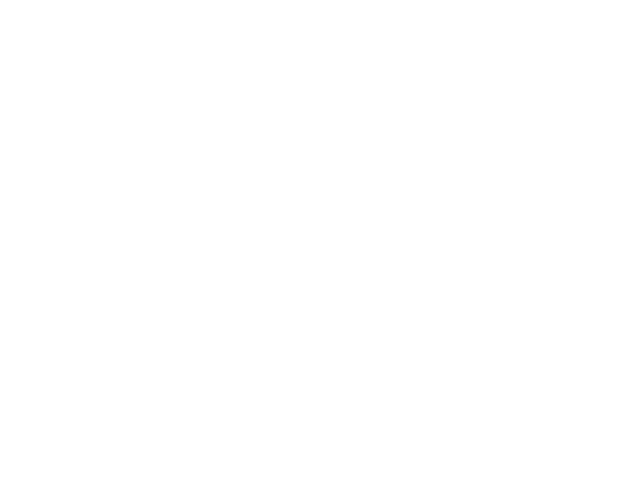

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [6]:
fig, ax = plt.subplots()

# plot the cumulative histogram

bins = np.arange(0, 1, 0.001) 
n, bins, patches = ax.hist(cbr["Congested"], bins=bins, density=True, histtype='step',
                           cumulative=True, label='C-V2X-No DCC', color="black")

ax.hist(cbr["DCC-Limeric-20%"], bins=bins, density=True, histtype='step',
        cumulative=True, label='DCC Adaptive', color="red")

ax.hist(cbr["DCC-Reactive-2018"], bins=bins, density=True, histtype='step', cumulative=True,
        label='DCC Reactive', color="blue")

ax.hist(cbr["PacketDropping"], bins=bins, density=True, histtype='step', cumulative=True,
        label='Packet Dropping', color="green")

ax.hist(cbr["rri-CRlimit-20%"], bins=bins, density=True, histtype='step', cumulative=True,
        label='RRI CR-Limit', color="darkorange")

ax.hist(cbr["rriLookup-2018"], bins=bins, density=True, histtype='step', cumulative=True,
        label='RRI Lookup', color="cyan")

# tidy up the figure
ax.grid(b=True, color="#d1d1d1")
ax.set_axisbelow(True)
ax.legend(loc='lower right')
ax.set_xlabel('Channel Busy Ratio %')
ax.set_ylabel('CDF')
ax.set_ylim([0,1])
ax.set_xlim([0,1])
ax.set_xticks(np.arange(0,1.01, 0.1))
ax.set_yticks(np.arange(0,1.01, 0.1))

legend_elements = [
    Line2D([0], [0], color='black', lw=2, label='C-V2X-No DCC'),
    Line2D([0], [0], color='red',   lw=2, label='DCC Adaptive'),
    Line2D([0], [0], color='blue',  lw=2, label='DCC Reactive'),
    Line2D([0], [0], color='green',  lw=2, label='Packet Dropping (Aggressive)'),
    Line2D([0], [0], color='darkorange',  lw=2, label='$RRI_{CR\_limit}$'),
    Line2D([0], [0], color='cyan',  lw=2, label='$RRI_{Lookup}$')
]

plt.legend(handles=legend_elements, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0, handlelength=1)

plt.tight_layout()

# plt.show()
plt.savefig("../data/figures/Congestion-Control-20pc-CBR-CDF.eps")
plt.close()

<IPython.core.display.Javascript object>


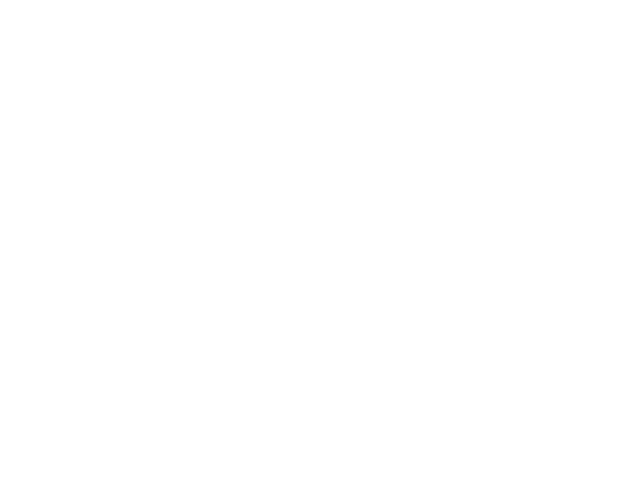

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [7]:
fig, ax = plt.subplots()

# plot the cumulative histogram

bins = np.arange(0, 1, 0.001) 
n, bins, patches = ax.hist(cbr["Congested"], bins=bins, density=True, histtype='step',
                           cumulative=True, label='C-V2X-No DCC', color="black")

ax.hist(cbr["DCC-Limeric-60%"], bins=bins, density=True, histtype='step',
        cumulative=True, label='DCC Adaptive', color="red")

ax.hist(cbr["rri-CRlimit-60%"], bins=bins, density=True, histtype='step', cumulative=True,
        label='RRI CR-Limit', color="blue")

# tidy up the figure
ax.grid(b=True, color="#d1d1d1")
ax.set_axisbelow(True)
ax.legend(loc='lower right')
ax.set_xlabel('Channel Busy Ratio %')
ax.set_ylabel('CDF')
ax.set_ylim([0,1])
ax.set_xlim([0,1])
ax.set_xticks(np.arange(0,1.01, 0.1))
ax.set_yticks(np.arange(0,1.01, 0.1))

legend_elements = [Line2D([0], [0], color='black', lw=2, label='C-V2X-No DCC'),
                   Line2D([0], [0], color='red',   lw=2, label='DCC Adaptive'),
                   Line2D([0], [0], color='blue',  lw=2, label='$RRI_{CR\_limit}$')]


plt.legend(handles=legend_elements, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0, handlelength=1)

plt.tight_layout()
# plt.show()
plt.savefig("../data/figures/Congestion-Control-60pc-CBR-CDF.eps")
plt.close()

<IPython.core.display.Javascript object>


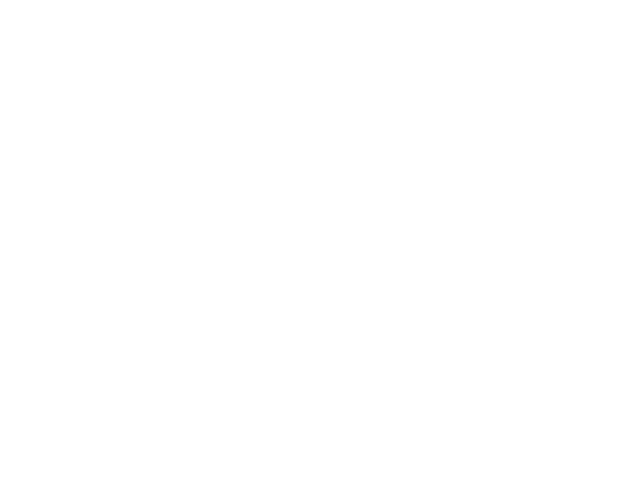

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [23]:
fig, ax = plt.subplots()

# plot the cumulative histogram

bins = np.arange(0, 1, 0.001) 
n, bins, patches = ax.hist(cbr["old-congested"], bins=bins, density=True, histtype='step',
                           cumulative=True, label='C-V2X-No DCC', color="black")

ax.hist(cbr["DCC Limeric 40%"], bins=bins, density=True, histtype='step',
        cumulative=True, label='DCC Adaptive', color="red")

ax.hist(cbr["RRI CR_LIMIT 40%"], bins=bins, density=True, histtype='step', cumulative=True,
        label='RRI CR-Limit', color="blue")

# tidy up the figure
ax.grid(b=True, color="#d1d1d1")
ax.set_axisbelow(True)
ax.legend(loc='lower right')
ax.set_xlabel('Channel Busy Ratio %')
ax.set_ylabel('CDF')
ax.set_ylim([0,1])
ax.set_xlim([0,1])
ax.set_xticks(np.arange(0,1.01, 0.1))
ax.set_yticks(np.arange(0,1.01, 0.1))

legend_elements = [Line2D([0], [0], color='black', lw=2, label='C-V2X-No DCC'),
                   Line2D([0], [0], color='red',   lw=2, label='DCC Adaptive'),
                   Line2D([0], [0], color='blue',  lw=2, label='$RRI_{CR\_limit}$')]


plt.legend(handles=legend_elements, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0, handlelength=1)

plt.tight_layout()

# plt.show()
plt.savefig("../data/figures/Congestion-Control-40pc-CBR-CDF.eps")
plt.close()

<IPython.core.display.Javascript object>


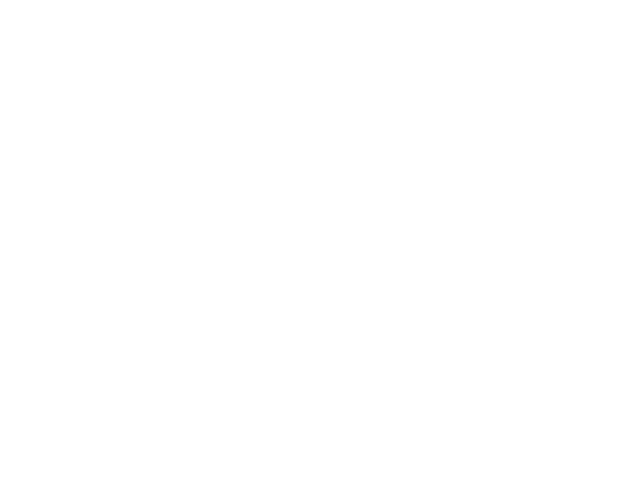

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [24]:
fig, ax = plt.subplots()

# plot the cumulative histogram

bins = np.arange(0, 1, 0.001) 
n, bins, patches = ax.hist(cbr["Congested"], bins=bins, density=True, histtype='step',
                           cumulative=True, label='C-V2X-No DCC', color="black")

ax.hist(cbr["PacketDropping-3GPP"], bins=bins, density=True, histtype='step',
        cumulative=True, label='Packet Dropping (3GPP)', color="red")

ax.hist(cbr["PacketDropping-ETSI"], bins=bins, density=True, histtype='step', cumulative=True,
        label='Packet Dropping (ETSI)', color="blue")

ax.hist(cbr["PacketDropping"], bins=bins, density=True, histtype='step', cumulative=True,
        label='Packet Dropping (Aggressive)', color="green")

handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
        
# tidy up the figure
ax.grid(b=True, color="#d1d1d1")
ax.set_axisbelow(True)
ax.set_xlabel('Channel Busy Ratio %')
ax.set_ylabel('CDF')
ax.set_ylim([0,1])
ax.set_xlim([0,1])
ax.set_xticks(np.arange(0,1.01, 0.1))
ax.set_yticks(np.arange(0,1.01, 0.1))


legend_elements = [Line2D([0], [0], color='black', lw=2, label='C-V2X-No DCC'),
                   Line2D([0], [0], color='red',   lw=2, label='Packet Dropping\n(3GPP)'),
                   Line2D([0], [0], color='blue',  lw=2, label='Packet Dropping (ETSI)'),
                   Line2D([0], [0], color='green', lw=2, label='Packet Dropping\n(Aggressive)')]


plt.legend(handles=legend_elements, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0, handlelength=0.5)

plt.tight_layout()

# plt.show()
plt.savefig("../data/figures/Pdrop-variants-CBR-CDF.eps")
plt.close()

In [2]:
configs = {
    "Congested": "/hdd/results-analysis/data/processed_data/congestion-control/extra-Congested-short-2021-05-08-17_42_52",
    "rri-CRlimit-60%": "/hdd/results-analysis/data/processed_data/congestion-control/rri-crlimit-60pc-test-2021-05-08-17_36_08",
    "DCC-Limeric-60%": "/hdd/results-analysis/data/processed_data/congestion-control/DCC-limeric-60pc-aware-2021-05-08-17_37_39"
}

In [3]:
awareness_1s = {}
for config in configs:
    print("="*40)
    positive_diff = []
    df = pd.read_csv("{}/raw-Awareness-1s.csv".format(configs[config]))
    awareness_1s[config] = df["awareness1sStat"].tolist()
    print("{}: {} +/- {}".format(config, df["awareness1sStat"].mean(), df["awareness1sStat"].std()))

Congested: 0.917842185136046 +/- 0.04487299418961426
rri-CRlimit-60%: 0.989734717223948 +/- 0.013775290769026385
DCC-Limeric-60%: 0.9303130969916983 +/- 0.04480183962281229


In [4]:
awareness_500ms = {}
for config in configs:
    print("="*40)
    positive_diff = []
    df = pd.read_csv("{}/raw-Awareness-500ms.csv".format(configs[config]))
    awareness_500ms[config] = df["awareness500msStat"].tolist()
    print("{}: {} +/- {}".format(config, df["awareness500msStat"].mean(), df["awareness500msStat"].std()))

Congested: 0.7997348788325511 +/- 0.06624723226641617
rri-CRlimit-60%: 0.9680967997866329 +/- 0.03116038808166685
DCC-Limeric-60%: 0.7924774730351755 +/- 0.07741846151739151


In [5]:
awareness_200ms = {}
for config in configs:
    print("="*40)
    positive_diff = []
    df = pd.read_csv("{}/raw-Awareness-200ms.csv".format(configs[config]))
    awareness_200ms[config] = df["awareness200msStat"].tolist()
    print("{}: {} +/- {}".format(config, df["awareness200msStat"].mean(), df["awareness200msStat"].std()))

Congested: 0.6864408237587196 +/- 0.09774792108286733
rri-CRlimit-60%: 0.8880607076115017 +/- 0.05708285513913251
DCC-Limeric-60%: 0.6975677745326999 +/- 0.09527466340025174


<IPython.core.display.Javascript object>


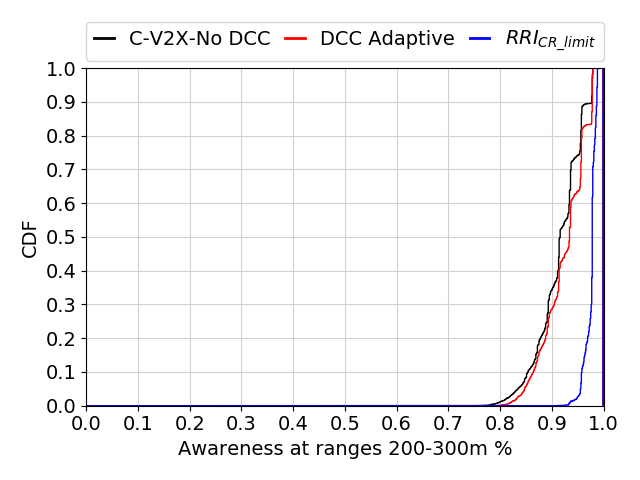

In [7]:
fig, ax = plt.subplots()

# plot the cumulative histogram

bins = np.arange(0, 1, 0.001) 
n, bins, patches = ax.hist(awareness_1s["Congested"], bins=bins, density=True, histtype='step',
                           cumulative=True, label='C-V2X-No DCC', color="black")

ax.hist(awareness_1s["DCC-Limeric-60%"], bins=bins, density=True, histtype='step',
        cumulative=True, label='DCC Adaptive', color="red")

ax.hist(awareness_1s["rri-CRlimit-60%"], bins=bins, density=True, histtype='step', cumulative=True,
        label='RRI CR-Limit', color="blue")

# tidy up the figure
ax.grid(b=True, color="#d1d1d1")
ax.set_axisbelow(True)
ax.legend(loc='lower right')
ax.set_xlabel('Awareness at ranges 200-300m %')
ax.set_ylabel('CDF')
ax.set_ylim([0,1])
ax.set_xlim([0,1])
ax.set_xticks(np.arange(0,1.01, 0.1))
ax.set_yticks(np.arange(0,1.01, 0.1))

legend_elements = [Line2D([0], [0], color='black', lw=2, label='C-V2X-No DCC'),
                   Line2D([0], [0], color='red',   lw=2, label='DCC Adaptive'),
                   Line2D([0], [0], color='blue',  lw=2, label='$RRI_{CR\_limit}$')]


plt.legend(handles=legend_elements, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0, handlelength=1)

plt.tight_layout()
plt.show()
# plt.savefig("../data/figures/Congestion-Control-60pc-CBR-CDF.eps")
# plt.close()

In [10]:
plt.close()

<IPython.core.display.Javascript object>


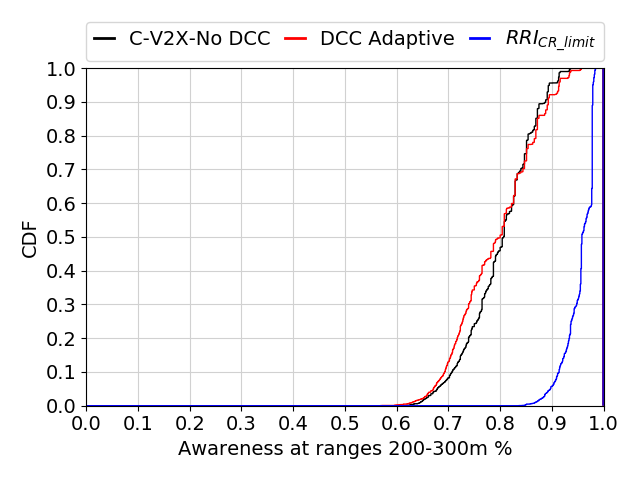

In [8]:
fig, ax = plt.subplots()

# plot the cumulative histogram

bins = np.arange(0, 1, 0.001) 
n, bins, patches = ax.hist(awareness_500ms["Congested"], bins=bins, density=True, histtype='step',
                           cumulative=True, label='C-V2X-No DCC', color="black")

ax.hist(awareness_500ms["DCC-Limeric-60%"], bins=bins, density=True, histtype='step',
        cumulative=True, label='DCC Adaptive', color="red")

ax.hist(awareness_500ms["rri-CRlimit-60%"], bins=bins, density=True, histtype='step', cumulative=True,
        label='RRI CR-Limit', color="blue")

# tidy up the figure
ax.grid(b=True, color="#d1d1d1")
ax.set_axisbelow(True)
ax.legend(loc='lower right')
ax.set_xlabel('Awareness at ranges 200-300m %')
ax.set_ylabel('CDF')
ax.set_ylim([0,1])
ax.set_xlim([0,1])
ax.set_xticks(np.arange(0,1.01, 0.1))
ax.set_yticks(np.arange(0,1.01, 0.1))

legend_elements = [Line2D([0], [0], color='black', lw=2, label='C-V2X-No DCC'),
                   Line2D([0], [0], color='red',   lw=2, label='DCC Adaptive'),
                   Line2D([0], [0], color='blue',  lw=2, label='$RRI_{CR\_limit}$')]


plt.legend(handles=legend_elements, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0, handlelength=1)

plt.tight_layout()
plt.show()
# plt.savefig("../data/figures/Congestion-Control-60pc-CBR-CDF.eps")
# plt.close()

In [11]:
plt.close()

<IPython.core.display.Javascript object>


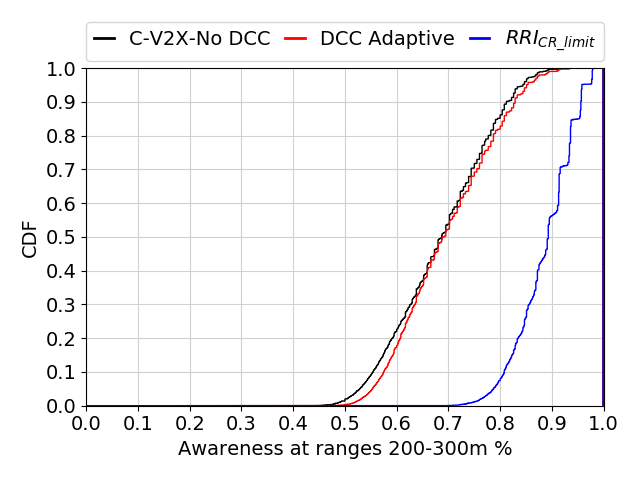

In [9]:
fig, ax = plt.subplots()

# plot the cumulative histogram

bins = np.arange(0, 1, 0.001) 
n, bins, patches = ax.hist(awareness_200ms["Congested"], bins=bins, density=True, histtype='step',
                           cumulative=True, label='C-V2X-No DCC', color="black")

ax.hist(awareness_200ms["DCC-Limeric-60%"], bins=bins, density=True, histtype='step',
        cumulative=True, label='DCC Adaptive', color="red")

ax.hist(awareness_200ms["rri-CRlimit-60%"], bins=bins, density=True, histtype='step', cumulative=True,
        label='RRI CR-Limit', color="blue")

# tidy up the figure
ax.grid(b=True, color="#d1d1d1")
ax.set_axisbelow(True)
ax.legend(loc='lower right')
ax.set_xlabel('Awareness at ranges 200-300m %')
ax.set_ylabel('CDF')
ax.set_ylim([0,1])
ax.set_xlim([0,1])
ax.set_xticks(np.arange(0,1.01, 0.1))
ax.set_yticks(np.arange(0,1.01, 0.1))

legend_elements = [Line2D([0], [0], color='black', lw=2, label='C-V2X-No DCC'),
                   Line2D([0], [0], color='red',   lw=2, label='DCC Adaptive'),
                   Line2D([0], [0], color='blue',  lw=2, label='$RRI_{CR\_limit}$')]


plt.legend(handles=legend_elements, bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0, handlelength=1)

plt.tight_layout()
plt.show()
# plt.savefig("../data/figures/Congestion-Control-60pc-CBR-CDF.eps")
# plt.close()

In [ ]:
plt.close()